### Clustering text documents using k-means

As an example we'll be using the 20 newsgroups dataset consists of 18000+ newsgroup posts on 20 topics. You can learn more about the dataset at http://qwone.com/~jason/20Newsgroups/

In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MiniBatchKMeans
import numpy as np

### Load data



In [2]:
newsgroups_train = fetch_20newsgroups(subset='train')
print(list(newsgroups_train.target_names))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


To keep it simple, let's filter only 3 topics. Assume that we do not know the topics, let's run clustering algorithm and examine the keywords of each clusters

In [3]:
categories = ['alt.atheism', 'comp.graphics', 'rec.motorcycles']

dataset = fetch_20newsgroups(subset='all', categories=categories, shuffle=True, random_state=2017)

print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))

labels = dataset.target

print("Extracting features from the dataset using a sparse vectorizer")
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(dataset.data)

print("n_samples: %d, n_features: %d" % X.shape)

2768 documents
3 categories
Extracting features from the dataset using a sparse vectorizer
n_samples: 2768, n_features: 35311


### LSA via SVD

Latent Semantic Analysis (LSA) is a mathematical method that tries to bring out latent relationships within a collection of documents. Rather than looking at each document isolated from the others it looks at all the documents as a whole and the terms within them to identify relationships. Let's perform LSA by running SVD on the data to reduce the dimensionality. 

SVD of matrix A = U * ∑ * VT

* r = rank of matrix X
* U = column orthonormal m * r matrix
* ∑ = diagonal r * r matrix with singular value sorted in descending order
* V = column orthonormal r * n matrix

In our case we have 3 topics, 2768 documents and 35311 word vocabulary. 

* Original matrix = 2768*35311 ~ 10^8
* SVD = 3*2768 + 3 + 3*35311 ~ 10^5.3

##### Resulted SVD is taking approximately 460 times less space than original matrix.

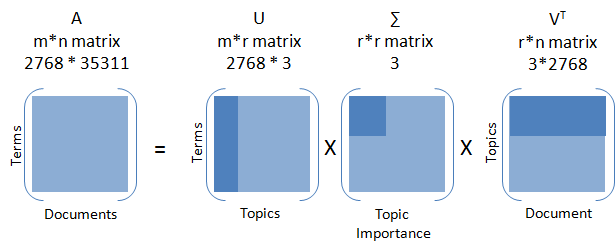

In [4]:
from IPython.display import Image
Image(filename='../Chapter 5 Figures/SVD.png', width=500)

In [5]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline

# Lets reduce the dimensionality to 2000
svd = TruncatedSVD(2000)
lsa = make_pipeline(svd, Normalizer(copy=False))

X = lsa.fit_transform(X)

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

Explained variance of the SVD step: 95%


### k-means clustering

In [6]:
from __future__ import print_function

km = KMeans(n_clusters=3, init='k-means++', max_iter=100, n_init=1)

# Scikit learn provides MiniBatchKMeans to run k-means in batch mode suitable for a very large corpus
# km = MiniBatchKMeans(n_clusters=5, init='k-means++', n_init=1, init_size=1000, batch_size=1000)

print("Clustering sparse data with %s" % km)
km.fit(X)

print("Top terms per cluster:")
original_space_centroids = svd.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
        
terms = vectorizer.get_feature_names()
for i in range(3):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=3, n_init=1, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)
Top terms per cluster:
Cluster 0: edu god keith com people sgi livesey writes caltech atheists
Cluster 1: com bike edu dod ca article writes sun like east
Cluster 2: edu graphics university lines subject organization com image thanks posting


### Hierarchical clustering

In [7]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(X)

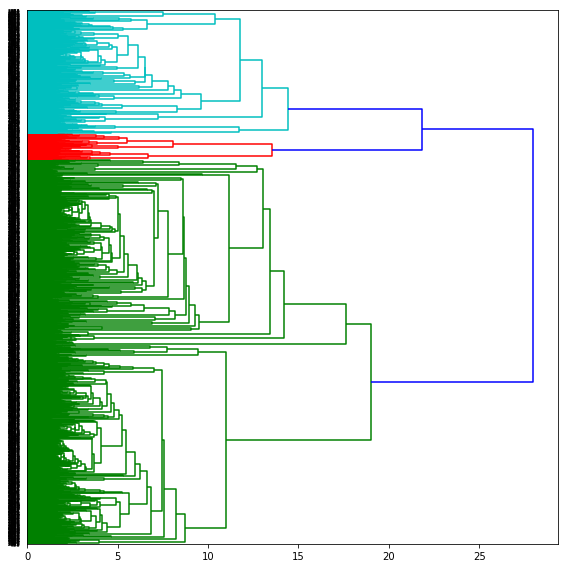

In [8]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(8, 8)) # set size
ax = dendrogram(linkage_matrix, orientation="right")

plt.tick_params(axis= 'x', which='both')

plt.tight_layout() #show plot with tight layout
plt.show()